## Import packages

In [5]:
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
import random
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")



## Read CSV, Split train-test

In [17]:
df = pd.read_csv('../data/otquad-v1.0 - Sheet1.csv')[['title', 'context',
                                                      'question', 'answer']]

print(len(df))
print(f"Number of Unique Contexts   : {df['context'].nunique()}")
print(f"Ratio of QA Pair-to-Context : {len(df)/df['context'].nunique()}")

df['context_length'] = df['context'].apply(len)
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)


In [23]:
# dff = df.sample(100, random_state=42)
# dff.to_csv('../data/sample_data.csv', index=False)

In [36]:
df_copy = deepcopy(df)
df_copy.drop_duplicates(subset='context', keep="last", inplace = True)
df_copy.reset_index(drop=True)
train_unique_context, test_unique_context = train_test_split(df_copy, 
                                                             test_size=0.2,
                                                             random_state=42)
train = pd.merge(train_unique_context, df, on="context")
test = pd.merge(test_unique_context, df, on="context")

assert np.array_equal(sorted(train_unique_context['context'].values),
                      sorted(np.unique(train['context'].values)))
assert np.array_equal(sorted(test_unique_context['context'].values),
                      sorted(np.unique(test['context'].values)))

In [37]:
# for i in range(len(train)):
#   for j in range(len(train)):
#     if i!=j:
#       if train['question_y'].values[i]==train['question_y'].values[j]:
#         print(train['question_y'].values[i])

In [38]:
len(train['context'].values), len(test['context'].values)

(417, 128)

In [39]:
def df_to_json(df, data_path, json_filename):
  start_index = [df['context'].values[i].lower().find(df['answer_y'].values[i].lower())
                 for i in range(len(df))]
  df['start_index_y'] = start_index

  for i in range(len(df)):
  #     print(i, start_index[i])
  #     print('Original : ',df['answer'].values[i].lower())
  #     print('Extracted: ', df['context'].values[i].lower()[start_index[i]:start_index[i]+len(df['answer'].values[i])])
      assert df['answer_y'].values[i].lower() == df['context'].values[i].lower()[
        start_index[i]:start_index[i]+len(df['answer_y'].values[i])]

  print(f'Unique Contexts: {len(np.unique(df.context.values))}\n Ratio of QA Pair-to-Contexts: {len(df)/len(np.unique(df.context.values))}')

  squad_entries= []
  for i in tqdm(range(len(df))):
    id_num      = i
    context     = df['context'].values[i]
    question    = df['question_y'].values[i]
    answer_text = df['answer_y'].values[i]
    start       = df['start_index_y'].values[i]
    title       = df['title_y'].values[i]

    if start!=-1:
      answer={"text":answer_text,"answer_start":int(start)}
    else:
      continue
    new_entry={
               "qas": [
                 {
                  "id": int(id_num),
                  "question": question,
                  "answers": [answer]
                 }
                 ],
               "context": context
               }
    squad_entries.append({"title":title,
                          "paragraphs":[new_entry]})
        

  squad_json={"data": squad_entries,
            "version":1.0}

  with open(data_path/json_filename, "w") as writer:
      writer.write(json.dumps(squad_json, indent=4) + "\n")



In [40]:
data_path = Path('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/otquad/')
df_to_json(train, data_path, 'train_otquad.json')
df_to_json(test, data_path, 'test_otquad.json')

100%|██████████| 128/128 [00:00<00:00, 37202.61it/s]

Unique Contexts: 51
 Ratio of QA Pair-to-Contexts: 8.176470588235293
Unique Contexts: 13
 Ratio of QA Pair-to-Contexts: 9.846153846153847


## Plot q-type frequency

In [41]:
def get_qtype_freq():
  q_list = df['question'].values.tolist()
  q_type = ['what', 'when', 'where', 'who', 'whom', 
            'which', 'why', 'how'] #, 'name', 'whose', 
  
  q_freq = {}
  for ques in q_list:
    q_tokens = ques.lower().split()
    for typ in q_type:
      if typ in q_tokens[0]:
        q_freq.setdefault(typ, []).append(ques)

  freq_qtype = [len(x) for x in list(q_freq.values())]
  print(freq_qtype, sum(freq_qtype))
  
  df_sorted = pd.DataFrame()
  df_sorted['QTYPE'] = q_type
  df_sorted['QFREQ'] = freq_qtype
  df_sorted['n'] = freq_qtype
  df_sorted = df_sorted.sort_values("QFREQ", ascending=False)

  return df_sorted
  

In [60]:
def plot_qtype_frequency(df_sorted):
  
  # Values for the x axis
  ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)

  # Cumulative length
  QFREQ = df_sorted["QFREQ"].values

  # # Mean gain length
  # MEAN_GAIN = df_sorted["mean_gain"].values

  # Region label
  QTYPE = df_sorted["QTYPE"].values

  # Number of tracks per region
  N = df_sorted["n"].values

  GREY12 = "#1f1f1f"

  # Set default font color to GREY12
  plt.rcParams["text.color"] = GREY12

  # The minus glyph is not available in Bell MT
  # This disables it, and uses a hyphen
  plt.rc("axes", unicode_minus=False)

  # Colors
  COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]

  # Colormap
  cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

  # Normalizer
  norm = mpl.colors.Normalize(vmin=N.min(), vmax=N.max())

  # Normalized colors. Each number of tracks is mapped to a color in the 
  # color scale 'cmap'
  COLORS = cmap(norm(N))

  # Some layout stuff ----------------------------------------------
  # Initialize layout in polar coordinates
  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

  # Set background color to white, both axis and figure.
  # fig.patch.set_facecolor("white")
  # ax.set_facecolor("white")

  ax.set_theta_offset(100 * np.pi / 3)
  ax.set_ylim(-100, 350)

  # Add geometries to the plot -------------------------------------
  # See the zorder to manipulate which geometries are on top

  # Add bars to represent the cumulative track lengths
  ax.bar(ANGLES, QFREQ, color=COLORS, alpha=1, width=0.6, zorder=11)

  # Add dashed vertical lines. These are just references
  ax.vlines(ANGLES, 0, 350, alpha=0.5, color=GREY12, ls=(0, (4, 4)), zorder=11)

  # # Add dots to represent the mean gain
  # ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)

  # Add labels for the regions -------------------------------------
  # Note the 'wrap()' function.
  # The '5' means we want at most 5 consecutive letters in a word, 
  # but the 'break_long_words' means we don't want to break words 
  # longer than 5 characters.
  QTYPE = ["\n".join(wrap(r, 5, break_long_words=False)) for r in QTYPE]

  # Set the labels
  ax.set_xticks(ANGLES)
  ax.set_xticklabels(QTYPE, size=15);

  plt.show()
  
  sns.set(style="whitegrid")
  colors = sns.color_palette('pastel')[0:len(df_sorted)]

  plt.subplots(figsize=(8, 15))
  explode = (0, 0.02, 0.03, 0.05, 0.1, 0.15, 0.4, 0.6)
  plt.pie(df_sorted['QFREQ'].values, labels=df_sorted['QTYPE'].values,
          explode=explode, colors = colors, autopct='%1.1f%%', shadow=False,
          textprops={'fontsize': 14})
  plt.xticks(size=25)
  plt.title("Distribution of 'type of questions'\nin OTQuAD", size=15)
  plt.show()


In [61]:
def density_plot_data(col_name_list, which_attr, figsize=(6,4)):
  plt.figure(figsize=figsize)
  for col_name in col_name_list:
    fig = sns.kdeplot(df[col_name], shade=True, label = col_name)
  plt.xticks(size=14)
  plt.yticks(size=14)
  plt.xlabel('Length', size=15)
  plt.ylabel('Density\n', size=15)
  plt.legend(loc='best', fontsize=14)
  plt.title(f"Distribution of '{which_attr}'\nin OTQuAD", size=15)
  plt.show()

In [ ]:
df_sorted = get_qtype_freq()
plot_qtype_frequency(df_sorted)

[292, 70, 47, 19, 30, 2, 7, 1] 468


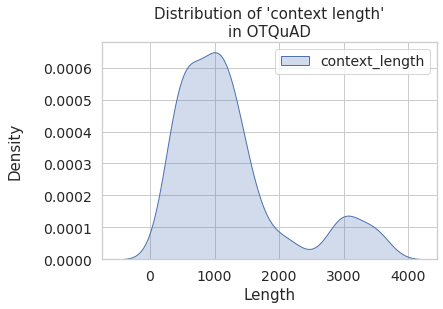

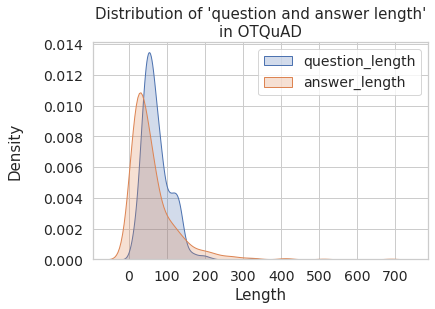

In [59]:
density_plot_data(['context_length'], 'context length')
density_plot_data(['question_length', 'answer_length'], 'question and answer length', figsize=(6,4))
